# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/scmemo')
import estimator, simulate, scmemo, bootstrap, util, hypothesis_test

In [9]:
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig4/'
data_path = '/data/'

### Perform some basic filtering

In [10]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B']))

In [11]:
def simplify_name(name):
    return name.split('.')[0]

In [12]:
adata = sc.read(data_path + 'interferon.h5ad')
adata = adata[(adata.obs.multiplets == 'singlet') & (adata.obs.cell != 'nan'), :].copy()
adata.X = adata.X.astype(np.int64)

In [13]:
adata.obs.cell.value_counts()

CD4 T cells          10389
CD14+ Monocytes      5385 
B cells              2573 
CD8 T cells          2042 
NK cells             1993 
FCGR3A+ Monocytes    1599 
Dendritic cells      432  
Megakaryocytes       260  
Name: cell, dtype: int64

In [14]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

... storing 'ind' as categorical
... storing 'stim' as categorical
... storing 'cluster' as categorical
... storing 'cell' as categorical
... storing 'multiplets' as categorical


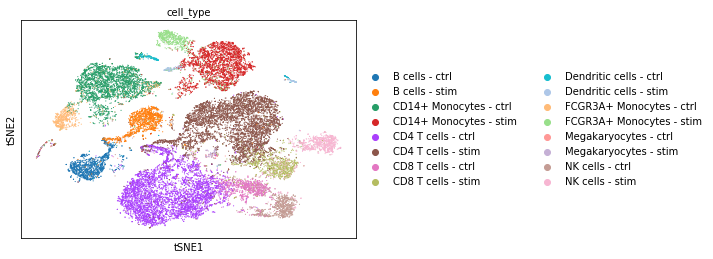

In [15]:
sc.pl.tsne(adata, color='cell_type')

In [16]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [17]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 35635


### Perform 1D hypothesis testing

In [55]:
imp.reload(hypothesis_test)
imp.reload(scmemo)
imp.reload(bootstrap)
imp.reload(estimator)

<module 'estimator' from '/home/ssm-user/Github/scrna-parameter-estimation/scmemo/estimator.py'>

### Read the hypothesis test result

In [70]:
adata_dict = {}
for ct in cts:
    adata_dict[ct] = sc.read(data_path + 'result_1d/ifn_{}.h5ad'.format(label_converter[ct]))

### Get a list of ISGF3 and IRF1 bound genes

In [ ]:
# Get the genes for ISGF3 (intersection of STAT1 and STAT2)
!~/bedtools closest \
    -a /data/chipseq/isgf3/stat1_stat2_intersect_6hr.sorted.bed \
    -b /data/chipseq/gene_tss_windows_20000.bed -d  > \
    /data/chipseq/isgf3/isgf3_genes_20000.bed

In [71]:
conversion_df = pd.read_csv('conversion.csv')[['Transcript stable ID', 'Gene name']]
conversion_df.columns = ['transcript_id', 'gene_name']

In [72]:
# isgf3 genes
isgf3_df = pd.read_csv(data_path + 'chipseq/isgf3/isgf3_genes.bed', sep='\t', header=None).iloc[:, [-2, -1]]
isgf3_df.columns=['transcript_id', 'distance']
isgf3_df = isgf3_df.query('distance == 0')
isgf3_df = isgf3_df.merge(conversion_df, on='transcript_id', how='inner')
isgf3_genes = isgf3_df['gene_name'].drop_duplicates().tolist()

In [73]:
ht_result_1d_dict = {}
for ct in cts:
    ht_result_1d_dict[ct] = scmemo.get_1d_ht_result(adata_dict[ct])
    ht_result_1d_dict[ct]['de_fdr'] = util._fdrcorrect(ht_result_1d_dict[ct]['de_pval'])
    ht_result_1d_dict[ct]['dv_fdr'] = util._fdrcorrect(ht_result_1d_dict[ct]['dv_pval'])
    ht_result_1d_dict[ct]['isgf3_binding'] = ht_result_1d_dict[ct]['gene'].apply(lambda x: x in isgf3_genes)
    ht_result_1d_dict[ct]['gene_type'] = ht_result_1d_dict[ct]['isgf3_binding'].apply(lambda x: 'ISGF3' if x else 'upreg')
    ht_result_1d_dict[ct]['ct'] = label_converter[ct]
    
    isfg3_dv = ht_result_1d_dict[ct].query('de_fdr < 0.05 & de_coef > 0 & isgf3_binding')['dv_coef']
    upreg_dv = ht_result_1d_dict[ct].query('de_fdr < 0.05 & de_coef > 0 & ~isgf3_binding')['dv_coef']
    
    print(ct, isfg3_dv.mean(), upreg_dv.mean(), stats.ks_2samp(isfg3_dv, upreg_dv)[1])
ht_result_1d_all = pd.concat([df for ct, df in ht_result_1d_dict.items()])

CD4 T cells -0.08609053616155715 -0.0044818599229671865 0.3003695917647503
CD14+ Monocytes -0.9491175361178692 -0.22827290829031446 1.1379416176016122e-07
FCGR3A+ Monocytes -0.7860962402068066 -0.23148774498895844 1.6804503355505318e-07
NK cells -0.5192243366851585 -0.08426371456973286 0.001939227959120382
CD8 T cells -0.3710467642392982 -0.02563126532356405 0.3582493036423846
B cells -0.46680584858096025 -0.03784498441821733 0.01432405659953484


In [75]:
ht_result_1d_all.to_csv('1d_result.csv', index=False)

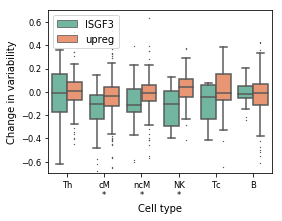

In [68]:
plt.figure(figsize=(4, 3))
sns.boxplot(
    x='ct', y='dv_coef', hue='gene_type',
    data=ht_result_1d_all.query('de_fdr < 0.05 & de_coef > 0'),
    palette=sns.color_palette('Set2'),
    fliersize=0.5)
#plt.plot([-1, 6], [0, 0], '--', lw=1, color='k')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=['Th', 'cM\n*', 'ncM\n*', 'NK\n*', 'Tc', 'B'])
plt.xlabel('Cell type'); plt.ylabel('Change in variability');
plt.legend(loc='upper left')
plt.ylim(-0.7, 0.7)
plt.savefig(fig_path + 'isgf3_vs_rest.pdf', bbox_inches='tight')

### DE effect size vs DV effect size by cell type

In [47]:
def plot_de_dv(ct, result_df):
    
    de_diff = result_df['de_coef']
    dv_diff = result_df['dv_coef']
    de_fdr = result_df['de_fdr']
    dv_fdr = result_df['dv_fdr']
    
    sig = (de_fdr < 0.1) & (dv_fdr < 0.1)
    plt.plot([0, 0], [-1, 1.1], '--', lw=2, color='k')
    plt.plot([-3, 5], [0, 0], '--', lw=2, color='k')
    plt.scatter(de_diff[~sig], dv_diff[~sig], s=1, color='grey')
    plt.scatter(de_diff[sig], dv_diff[sig], s=5, color='g')
        
    plt.xlabel('$\Delta$Mean')
    if ct in ['NK cells', 'CD4 T cells']:
        plt.ylabel('$\Delta$Variability')
    
    print(ct, util.robust_correlation(de_diff, dv_diff))

    plt.title(ct)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(2))

CD4 T cells SpearmanrResult(correlation=0.0003413059610538602, pvalue=0.9888967334266912)
CD14+ Monocytes SpearmanrResult(correlation=-0.2105857012228761, pvalue=3.255839915744383e-21)
FCGR3A+ Monocytes SpearmanrResult(correlation=-0.08843265374995289, pvalue=0.0015869791103201886)


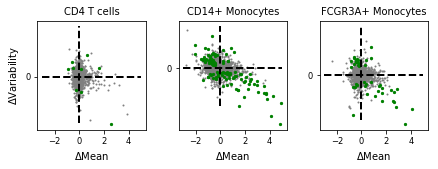

In [48]:
plt.figure(figsize=(7, 2))
plt.subplots_adjust(hspace=0.45, wspace=0.3)
for idx, ct in enumerate(cts[:3]):
    plt.subplot(1, 3, idx+1)
    plot_de_dv(ct, ht_result_1d_dict[ct])
plt.savefig(fig_path + 'de_vs_dv.png', bbox_inches='tight')
    

### Single gene example

In [402]:
def plot_bar_strip(gene, ct_to_include=None):
    
    ct_list = cts if ct_to_include is None else ct_to_include
    expr_df_list = []
    for ct in ct_list:
        if gene in adata_dict[ct].var.index:
            gene_idx = adata_dict[ct].var.index.tolist().index(gene)
            for group in adata_dict[ct].uns['scmemo']['groups']:
                expr_df_list.append((label_converter[ct], group.split('^')[0], group.split('^')[1], np.log(adata_dict[ct].uns['scmemo']['1d_moments'][group][0][gene_idx]), adata_dict[ct].uns['scmemo']['1d_moments'][group][2][gene_idx]))
    expr_df = pd.DataFrame(expr_df_list, columns=['ct','ind', 'stim', 'mean', 'variability'])

    plt.figure(figsize=(3, 3))
    plt.subplots_adjust(hspace=0.1)

    plt.subplot(2, 1, 1)
    plt.title('{} expression in response to IFN-B'.format(gene))

    ax = sns.boxplot(x='ct', y='mean', data=expr_df, hue='stim', palette=sns.color_palette('Set2'))
    ax = sns.stripplot(x='ct', y='mean', data=expr_df, hue='stim', dodge=True, palette=sns.color_palette('Set2'), edgecolor='grey', linewidth=2)
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks([]); plt.xlabel('')

    plt.subplot(2, 1, 2)
    ax = sns.boxplot(x='ct', y='variability', data=expr_df, hue='stim', palette=sns.color_palette('Set2'))
    ax = sns.stripplot(x='ct', y='variability', data=expr_df, hue='stim', dodge=True, palette=sns.color_palette('Set2'), edgecolor='grey', linewidth=2)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend_.remove()

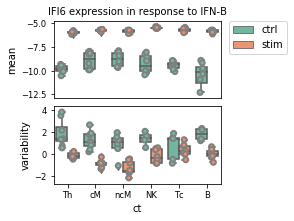

In [403]:
plot_bar_strip('IFI6', ct_to_include=None)
plt.savefig(fig_path + 'across_ct_{}.pdf'.format('IFI6'), bbox_inches='tight')

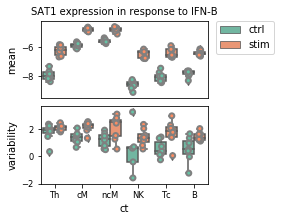

In [404]:
plot_bar_strip('SAT1', ct_to_include=None)
plt.savefig(fig_path + 'across_ct_{}.pdf'.format('SAT1'), bbox_inches='tight')

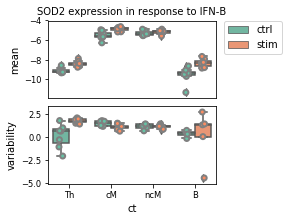

In [405]:
# plot_bar_strip('LGALS3', ct_to_include=['CD14+ Monocytes', 'FCGR3A+ Monocytes'])
plot_bar_strip('SOD2', ct_to_include=None)
plt.savefig(fig_path + 'across_ct_{}.pdf'.format('SOD2'), bbox_inches='tight')

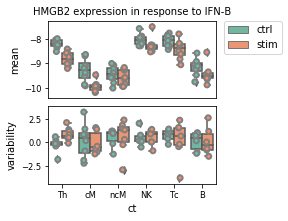

In [406]:
plot_bar_strip('HMGB2', ct_to_include=None)
plt.savefig(fig_path + 'across_ct_{}.pdf'.format('HMGB2'), bbox_inches='tight')

### P-value calibrations

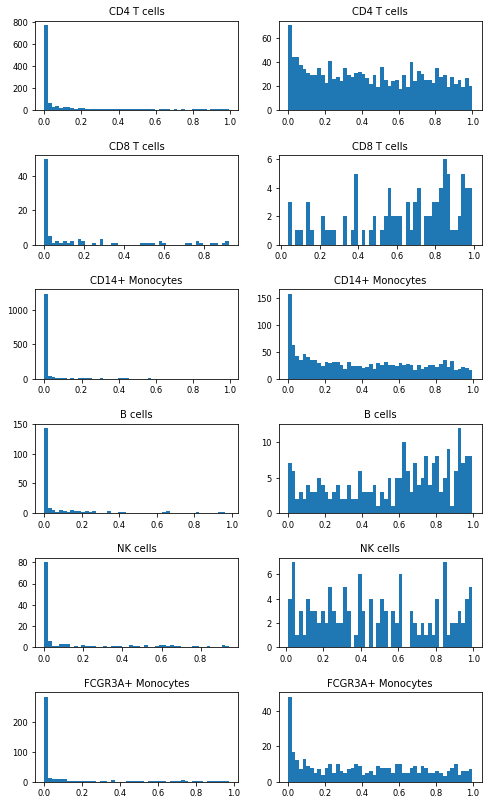

In [59]:
plt.figure(figsize=(8, 14))
plt.subplots_adjust(hspace=0.5)

for idx, ct in enumerate(['CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes', 'B cells', 'NK cells', 'FCGR3A+ Monocytes']):
    
    plt.subplot(6, 2, 2*idx+1);
    plt.hist(adata_dict[ct].uns['scmemo']['1d_ht']['mean_asl'], bins=50);
    plt.title('{}'.format(ct))
    
    plt.subplot(6, 2, 2*idx+2);
    plt.hist(adata_dict[ct].uns['scmemo']['1d_ht']['var_asl'], bins=50);
    plt.title('{}'.format(ct))
plt.savefig('de_dv_calibration.pdf', bbox_inches='tight')

### Calibration debugging


In [18]:
%%time
imp.reload(scmemo)
imp.reload(bootstrap)
imp.reload(estimator)
imp.reload(hypothesis_test)
imp.reload(util)

test_adata = adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
# test_adata.obs['stim'] = np.random.choice(test_adata.obs['stim'], test_adata.shape[0])
scmemo.create_groups(test_adata, label_columns=['ind','stim'], inplace=True)
scmemo.compute_1d_moments(
    test_adata, inplace=True, filter_genes=True, 
    residual_var=True, use_n_umi=False, filter_mean_thresh=0.1, 
    min_perc_group=0.9)
print('Number of genes kept: {}'.format(test_adata.shape[1]))

Number of genes kept: 521
CPU times: user 248 ms, sys: 59.6 ms, total: 308 ms
Wall time: 285 ms


In [20]:
%%time

imp.reload(scmemo)
imp.reload(bootstrap)
imp.reload(estimator)
imp.reload(hypothesis_test)
imp.reload(util)

a = scmemo.ht_1d_moments(
    test_adata, 
    formula_like='1 + stim', 
    cov_column='stim', 
    num_boot=10000, 
    verbose=True,
    num_cpus=5)

Process ForkPoolWorker-11:
Traceback (most recent call last):


KeyboardInterrupt: 

  File "/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/multiprocess/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/pathos/helpers/mp_helper.py", line 15, in <lambda>
    func = lambda args: f(*args)
  File "/home/ssm-user/Github/scrna-parameter-estimation/scmemo/hypothesis_test.py", line 106, in _ht_1d
    n_umi=adata_dict['n_umi'])
  File "/home/ssm-user/Github/scrna-parameter-estimation/scmemo/bootstrap.py", line 57, in _bootstrap_1d
    gene_rvs = stats.poisson.rvs(counts, size=(num_boot, counts.shape[0])).T
  File "/home/ssm-user/anaconda3/envs/single_cell

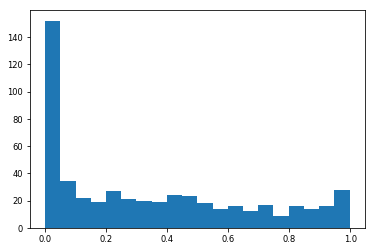

In [51]:
plt.hist(test_adata.uns['scmemo']['1d_ht']['var_asl'], bins=20);

In [53]:
from p_tqdm import p_map

In [30]:
actual_moments_1 = test_adata.uns['scmemo']['1d_moments']['sg^ctrl'][:2]
actual_moments_2 = test_adata.uns['scmemo']['1d_moments']['sg^stim'][:2]

In [31]:
actual_rv_1 = test_adata.uns['scmemo']['1d_moments']['sg^ctrl'][2]
actual_rv_2 = test_adata.uns['scmemo']['1d_moments']['sg^stim'][2]
actual_rv_ratio = np.log((actual_rv_2+5)/(actual_rv_1+5))

In [32]:
boot_means_1 = []
boot_vars_1 = []
boot_means_2 = []
boot_vars_2 = []
for g in range(test_adata.shape[1]):
    mean, var = a[g]
    
    boot_means_1.append(mean[0, 1:])
    boot_means_2.append(mean[1, 1:])
    boot_vars_1.append(var[0, 1:])
    boot_vars_2.append(var[1, 1:])
means_1 = np.array(boot_means_1).T
vars_1 = np.array(boot_vars_1).T
means_2 = np.array(boot_means_2).T
vars_2 = np.array(boot_vars_2).T

rvs_1, rvs_2 = np.array(vars_1/means_1)+5, np.array(vars_2/means_1)+5
boot_rv_ratio = np.log(rvs_2/rvs_1)
# boot_rv_ratio = np.log(rvs_2/rvs_1)
c = ((boot_rv_ratio > 0).sum(axis=0)+1)/(boot_rv_ratio.shape[0]+1)
rv_pvals = 2*np.minimum(c, 1-c)

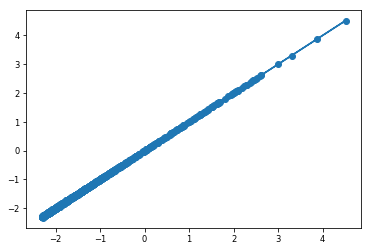

In [33]:
plt.scatter(
    np.log(actual_moments_1[0]),
    np.log(means_1.mean(axis=0)))
plt.plot(np.log(actual_moments_1[0]), np.log(actual_moments_1[0]))
    

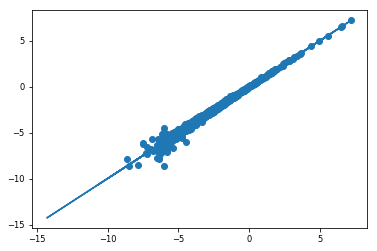

In [34]:
plt.scatter(
    np.log(actual_moments_1[1]),
    np.log(vars_1.mean(axis=0)))
plt.plot(np.log(actual_moments_1[1]), np.log(actual_moments_1[1]))
    

In [35]:
test_adata.uns['scmemo']['approx_size_factor']['sg^stim']

array([0.67119546, 1.80956489, 0.67119546, ..., 1.19515085, 0.92651602,
       1.63687108])

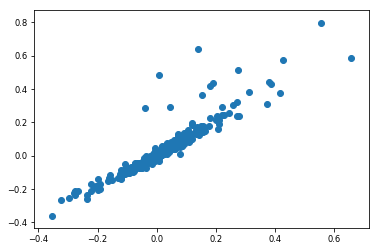

In [36]:
plt.scatter(
    actual_rv_ratio,
    boot_rv_ratio.mean(axis=0))
    

(array([155., 165., 117., 165., 109., 165.,  97., 144., 145., 161.]),
 array([0.        , 0.09803922, 0.19607843, 0.29411765, 0.39215686,
        0.49019608, 0.58823529, 0.68627451, 0.78431373, 0.88235294,
        0.98039216]),
 <a list of 10 Patch objects>)

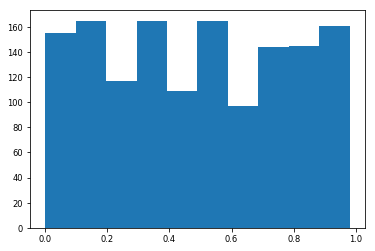

In [37]:
plt.hist(rv_pvals)

In [150]:
%%time

num_boot = 100
moments_1, moments_2 = [], []
cell_count_1, cell_count_2 = [], []

for boot_trial in range(num_boot):
    boot_idxs = np.random.choice(test_adata.shape[0], test_adata.shape[0])
    
    boot_mat = test_adata.X[boot_idxs, :]
    boot_label = test_adata.obs['stim'][boot_idxs]
    size_factors = test_adata.uns['scmemo']['all_size_factor'][boot_idxs]
#     size_factors = approx_sf
    
    boot_idxs_1 = (boot_label == 'ctrl').values
    boot_idxs_2 = (boot_label == 'stim').values
    
    moments_1.append(
        estimator._poisson_1d(
            boot_mat[boot_idxs_1],
            boot_idxs_1.shape[0],
            size_factors[boot_idxs_1])
    )
    moments_2.append(
        estimator._poisson_1d(
            boot_mat[boot_idxs_2],
            boot_idxs_2.shape[0],
            size_factors[boot_idxs_2])
    )
    cell_count_1.append(boot_idxs_1.shape[0])
    cell_count_2.append(boot_idxs_2.shape[0])
    

CPU times: user 1.45 s, sys: 0 ns, total: 1.45 s
Wall time: 1.45 s


In [151]:
means_1, vars_1, means_2, vars_2, rvs_1, rvs_2 = [],[],[],[], [], []
for boot_trial in range(num_boot):
    
    means_1.append(moments_1[boot_trial][0])
    vars_1.append(moments_1[boot_trial][1])

    means_2.append(moments_2[boot_trial][0])
    vars_2.append(moments_2[boot_trial][1])
    
    rvs_1.append(moments_1[boot_trial][1]/(a*moments_1[boot_trial][0]**b))
    rvs_2.append(moments_2[boot_trial][1]/(a*moments_2[boot_trial][0]**b))

means_1, vars_1, means_2, vars_2 = np.array(means_1), np.array(vars_1), np.array(means_2), np.array(vars_2)

rvs_1, rvs_2 = np.array(rvs_1)+5, np.array(rvs_2)+5

actual_rv_ratio = actual_rv_2/actual_rv_1
boot_rv_ratio = np.log(rvs_2/rvs_1)

# centered = boot_rv_ratio/actual_rv_ratio
# c = (centered > actual_rv_ratio).mean(axis=0)
c = ((boot_rv_ratio > 0).sum(axis=0)+1)/(boot_rv_ratio.shape[0]+1)
rv_pvals = 2*np.minimum(c, 1-c)


(array([ 5.,  4.,  8.,  6., 18., 20., 18., 13.,  3.,  5.]),
 array([2.55456204, 2.60479013, 2.65501822, 2.7052463 , 2.75547439,
        2.80570248, 2.85593057, 2.90615865, 2.95638674, 3.00661483,
        3.05684291]),
 <a list of 10 Patch objects>)

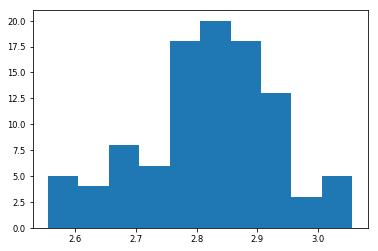

In [155]:
plt.hist(means_1[:, 0])

In [82]:
boot_means_1 = []
boot_vars_1 = []
boot_means_2 = []
boot_vars_2 = []
for g in range(test_adata.shape[1]):
    mean, var = a[g]
    
    boot_means_1.append(mean[0, :])
    boot_means_2.append(mean[1, :])
    boot_vars_1.append(var[0, :])
    boot_vars_2.append(var[1, :])
means_1 = np.array(boot_means_1).T
vars_1 = np.array(boot_vars_1).T
means_2 = np.array(boot_means_2).T
vars_2 = np.array(boot_vars_2).T

rvs_1, rvs_2 = np.array(vars_1/means_1)+5, np.array(vars_2/means_1)+5
boot_rv_ratio = np.log(rvs_2/rvs_1)
# boot_rv_ratio = np.log(rvs_2/rvs_1)
c = ((boot_rv_ratio > 0).sum(axis=0)+1)/(boot_rv_ratio.shape[0]+1)
rv_pvals = 2*np.minimum(c, 1-c)

In [86]:
with open ('temp.pkl','wb') as f:
    pkl.dump(boot_rv_ratio, f)

(array([261., 135., 162., 154., 101., 148., 108., 119., 114., 128.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

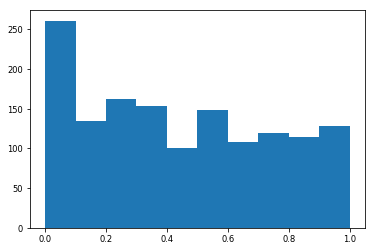

In [81]:
plt.hist(rv_pvals)

(array([ 2.,  0.,  5.,  3.,  7., 10., 32., 21., 20.,  1.]),
 array([-0.32893624, -0.29134723, -0.25375822, -0.21616921, -0.17858021,
        -0.1409912 , -0.10340219, -0.06581318, -0.02822417,  0.00936484,
         0.04695384]),
 <a list of 10 Patch objects>)

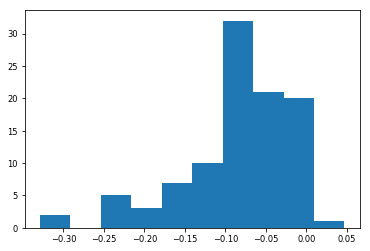

In [76]:
plt.hist(boot_rv_ratio[:, 1])

In [46]:
plt.hist(test_adata.uns['scmemo']['1d_ht']['var_asl'], bins=20);

KeyError: '1d_ht'

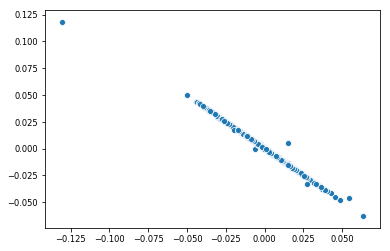

In [176]:
sns.scatterplot(
    test_adata.uns['scmemo']['1d_ht']['mean_coef'],
    test_adata.uns['scmemo']['1d_ht']['var_coef'],

)
# plt.ylim(-0.0001, 0.0001)

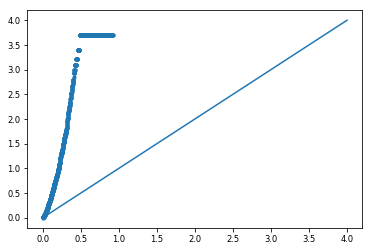

In [160]:
x = np.sort(test_adata.uns['scmemo']['1d_ht']['var_asl'])

plt.scatter(
    -np.log10(np.linspace(0, 1, x.shape[0])), 
    -np.log10(x), s=10)
plt.plot([0, 4], [0, 4])